In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
df=pd.read_excel("Final_Neonatal data.xlsx")

In [3]:
df.shape

(3009, 44)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3009 entries, 0 to 3008
Data columns (total 44 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CardNumber          3009 non-null   int64  
 1   RegistrationDate    3009 non-null   object 
 2   FullName            2999 non-null   object 
 3   Sex                 2993 non-null   object 
 4   Region              3009 non-null   object 
 5   Zone                3009 non-null   object 
 6   Wereda              2996 non-null   object 
 7   Kebele              2996 non-null   float64
 8   AgeInDay            3009 non-null   float64
 9   AgeInHour           3009 non-null   float64
 10  Wight               3009 non-null   float64
 11  Diagnosis           3001 non-null   object 
 12  TotalWBC            3009 non-null   float64
 13  Hemoglobin          3009 non-null   float64
 14  Hematocrit          3009 non-null   float64
 15  Platelet            3009 non-null   float64
 16  BloodR

In [5]:
df.isnull().sum()

CardNumber               0
RegistrationDate         0
FullName                10
Sex                     16
Region                   0
Zone                     0
Wereda                  13
Kebele                  13
AgeInDay                 0
AgeInHour                0
Wight                    0
Diagnosis                8
TotalWBC                 0
Hemoglobin               0
Hematocrit               0
Platelet                 0
BloodRH1                 0
RBS                      0
ESR                      0
CRP                      0
APGARscore             632
Direct                   0
Indirect                 0
Total                    0
Na                       0
Ca                       0
K                        0
Mg                       0
Xray                  2915
US                    2845
EchoCard              2976
CTScan                3000
ManagmentDecision       20
AgeMother                0
Gravidity                0
Parity                   0
BloodRH2                 0
H

In [6]:
drop_cols = [
    'CardNumber', 'FullName', 'Region', 'Zone', 'Wereda', 'Kebele',
    'APGARscore','Xray', 'US', 'EchoCard', 'CTScan', 'Hepatatis',
    'Unnamed: 44', '1'
]

# Filter out columns that do not exist in the DataFrame
existing_drop_cols = [col for col in drop_cols if col in df.columns]

# Drop only the existing columns
d = df.drop(columns=existing_drop_cols)

print(f"Dropped columns: {existing_drop_cols}")
print("Remaining columns:")
print(d.columns.tolist())

Dropped columns: ['CardNumber', 'FullName', 'Region', 'Zone', 'Wereda', 'Kebele', 'APGARscore', 'Xray', 'US', 'EchoCard', 'CTScan', 'Hepatatis']
Remaining columns:
['RegistrationDate', 'Sex', 'AgeInDay', 'AgeInHour', 'Wight', 'Diagnosis', 'TotalWBC', 'Hemoglobin', 'Hematocrit', 'Platelet', 'BloodRH1', 'RBS', 'ESR', 'CRP', 'Direct', 'Indirect', 'Total', 'Na', 'Ca', 'K', 'Mg', 'ManagmentDecision', 'AgeMother', 'Gravidity', 'Parity', 'BloodRH2', 'HIV', 'GestesionalAge', 'PlaceofDeli', 'UDRL', 'DischargeDate', 'DischargeCondition']


In [7]:
d.to_excel('Final_Neonatal datanew.xlsx', index=False)

In [8]:
d=pd.read_excel('Final_Neonatal datanew.xlsx')

In [9]:
d.shape

(3009, 32)

In [10]:
# Check how many samples per class
print(d['DischargeCondition'].value_counts())

DischargeCondition
Improved    2501
Died         368
LAMA         108
Transfer      32
Name: count, dtype: int64


In [11]:
d.drop_duplicates(inplace=True)

In [41]:
d.shape

(1180, 32)

In [12]:
print(d['DischargeCondition'].value_counts())

DischargeCondition
Improved    977
Died        149
LAMA         42
Transfer     12
Name: count, dtype: int64


In [13]:
d.isnull().sum()

RegistrationDate       0
Sex                    6
AgeInDay               0
AgeInHour              0
Wight                  0
Diagnosis              3
TotalWBC               0
Hemoglobin             0
Hematocrit             0
Platelet               0
BloodRH1               0
RBS                    0
ESR                    0
CRP                    0
Direct                 0
Indirect               0
Total                  0
Na                     0
Ca                     0
K                      0
Mg                     0
ManagmentDecision      8
AgeMother              0
Gravidity              0
Parity                 0
BloodRH2               0
HIV                    0
GestesionalAge        27
PlaceofDeli            0
UDRL                  34
DischargeDate          0
DischargeCondition     0
dtype: int64

In [14]:
mode_sex = d['Sex'].mode()[0]
d['Sex'] = d['Sex'].fillna(mode_sex)

In [15]:
mode_diagnosis = d['Diagnosis'].mode()[0]
d['Diagnosis'] = d['Diagnosis'].fillna(mode_diagnosis)

In [16]:
mode_ManagmentDecision = d['ManagmentDecision'].mode()[0]
d['ManagmentDecision'] = d['ManagmentDecision'].fillna(mode_ManagmentDecision)

In [17]:
mode_ManagmentDecision = d['ManagmentDecision'].mode()[0]
d['ManagmentDecision'] = d['ManagmentDecision'].fillna(mode_ManagmentDecision)

In [18]:
mean_GestesionalAge = d['GestesionalAge'].mean()
d['GestesionalAge'] = d['GestesionalAge'].fillna(mean_GestesionalAge)

In [19]:
mean_udrl = d['UDRL'].mean()
d['UDRL'] = d['UDRL'].fillna(mean_udrl)

In [20]:
d.isnull().sum()

RegistrationDate      0
Sex                   0
AgeInDay              0
AgeInHour             0
Wight                 0
Diagnosis             0
TotalWBC              0
Hemoglobin            0
Hematocrit            0
Platelet              0
BloodRH1              0
RBS                   0
ESR                   0
CRP                   0
Direct                0
Indirect              0
Total                 0
Na                    0
Ca                    0
K                     0
Mg                    0
ManagmentDecision     0
AgeMother             0
Gravidity             0
Parity                0
BloodRH2              0
HIV                   0
GestesionalAge        0
PlaceofDeli           0
UDRL                  0
DischargeDate         0
DischargeCondition    0
dtype: int64

In [42]:


def clinical_entropy_matched_oversample(
    d,
    target_col,
    total_size=None,
    target_entropy=1.23,
    noise_level=0.02,
    random_state=42
):

    d = d.copy()
    numeric_cols = d.select_dtypes(include=[np.number]).columns.tolist()
    if target_col in numeric_cols:
        numeric_cols.remove(target_col)  # avoid adding noise to target

    counts = d[target_col].value_counts()
    classes = counts.index.tolist()
    freqs = counts.values.astype(float)

    log_freqs = np.log(freqs)

    def entropy(p):
        return -np.sum(p * np.log(p + 1e-9))

    if total_size is None:
        total_size = len(d)

    if target_entropy is None:
        # maximum entropy for current number of classes
        target_entropy = np.log(len(classes))

    # Search temperature
    best_T, best_diff, best_p = None, 1e9, None
    for T in np.linspace(0.1, 5, 5000):
        logits = log_freqs / T
        p = np.exp(logits) / np.exp(logits).sum()
        diff = abs(entropy(p) - target_entropy)
        if diff < best_diff:
            best_T, best_diff, best_p = T, diff, p

    # Final target counts
    targets = dict(zip(classes, (best_p * total_size).astype(int)))

    augmented = [d]

    for cls, target_n in targets.items():
        class_d = d[d[target_col] == cls]
        n_current = len(class_d)

        if target_n <= n_current:
            continue

        n_needed = target_n - n_current
        sampled = class_d.sample(n=n_needed, replace=True, random_state=random_state).copy()

        # Add noise to numeric columns
        for col in numeric_cols:
            std = d[col].std()
            if std > 0:
                sampled[col] += np.random.normal(0, noise_level * std, size=n_needed)

        # Optional: cast integers back if original column is int
        for col in numeric_cols:
            if pd.api.types.is_integer_dtype(d[col]):
                sampled[col] = sampled[col].round().astype(d[col].dtype)

        augmented.append(sampled)

    df_aug = pd.concat(augmented, ignore_index=True)
    df_aug = df_aug.sample(frac=1, random_state=random_state).reset_index(drop=True)
    return df_aug


In [43]:
df_aug = clinical_entropy_matched_oversample(
    d,
    target_col='DischargeCondition',
    total_size=2065,
    target_entropy=1.23,
    noise_level=0.02
)

df_aug.to_excel('Final_Neonatal_data_augmentedml.xlsx', index=False)


In [44]:
df_aug.shape

(2063, 32)

In [45]:
df_aug = clinical_entropy_matched_oversample(
    d,
    target_col='DischargeCondition',
    total_size=2065
)

df_aug['DischargeCondition'].value_counts(normalize=True)

DischargeCondition
Improved    0.482307
Died        0.251091
LAMA        0.161900
Transfer    0.104702
Name: proportion, dtype: float64

In [46]:
print(df_aug['DischargeCondition'].value_counts())

DischargeCondition
Improved    995
Died        518
LAMA        334
Transfer    216
Name: count, dtype: int64


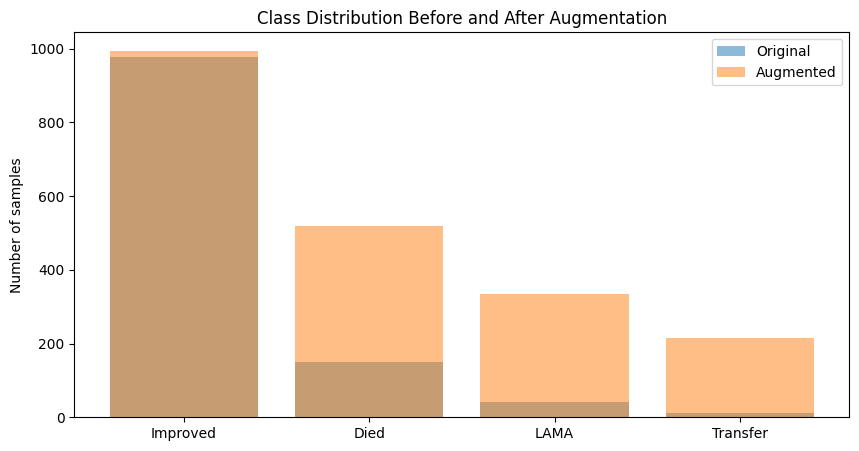

In [47]:
# Before augmentation
original_counts = d['DischargeCondition'].value_counts()

# After augmentation
aug_counts = df_aug['DischargeCondition'].value_counts()

plt.figure(figsize=(10,5))
plt.bar(original_counts.index, original_counts.values, alpha=0.5, label='Original')
plt.bar(aug_counts.index, aug_counts.values, alpha=0.5, label='Augmented')
plt.ylabel('Number of samples')
plt.title('Class Distribution Before and After Augmentation')
plt.legend()
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_13176\4044545383.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_encoded[col] = pd.to_datetime(X[col])
C:\Users\HP\AppData\Local\Temp\ipykernel_13176\4044545383.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_encoded[col] = pd.to_datetime(X[col])
C:\Users\HP\AppData\Local\Temp\ipykernel_13176\4044545383.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_encoded[col] = pd.to_datetime(X[col])
C:\Users\HP\AppData\Local\Temp\ipykernel_13176\4044545383.py:21: UserWarning: Could not infer format, so each element will be p

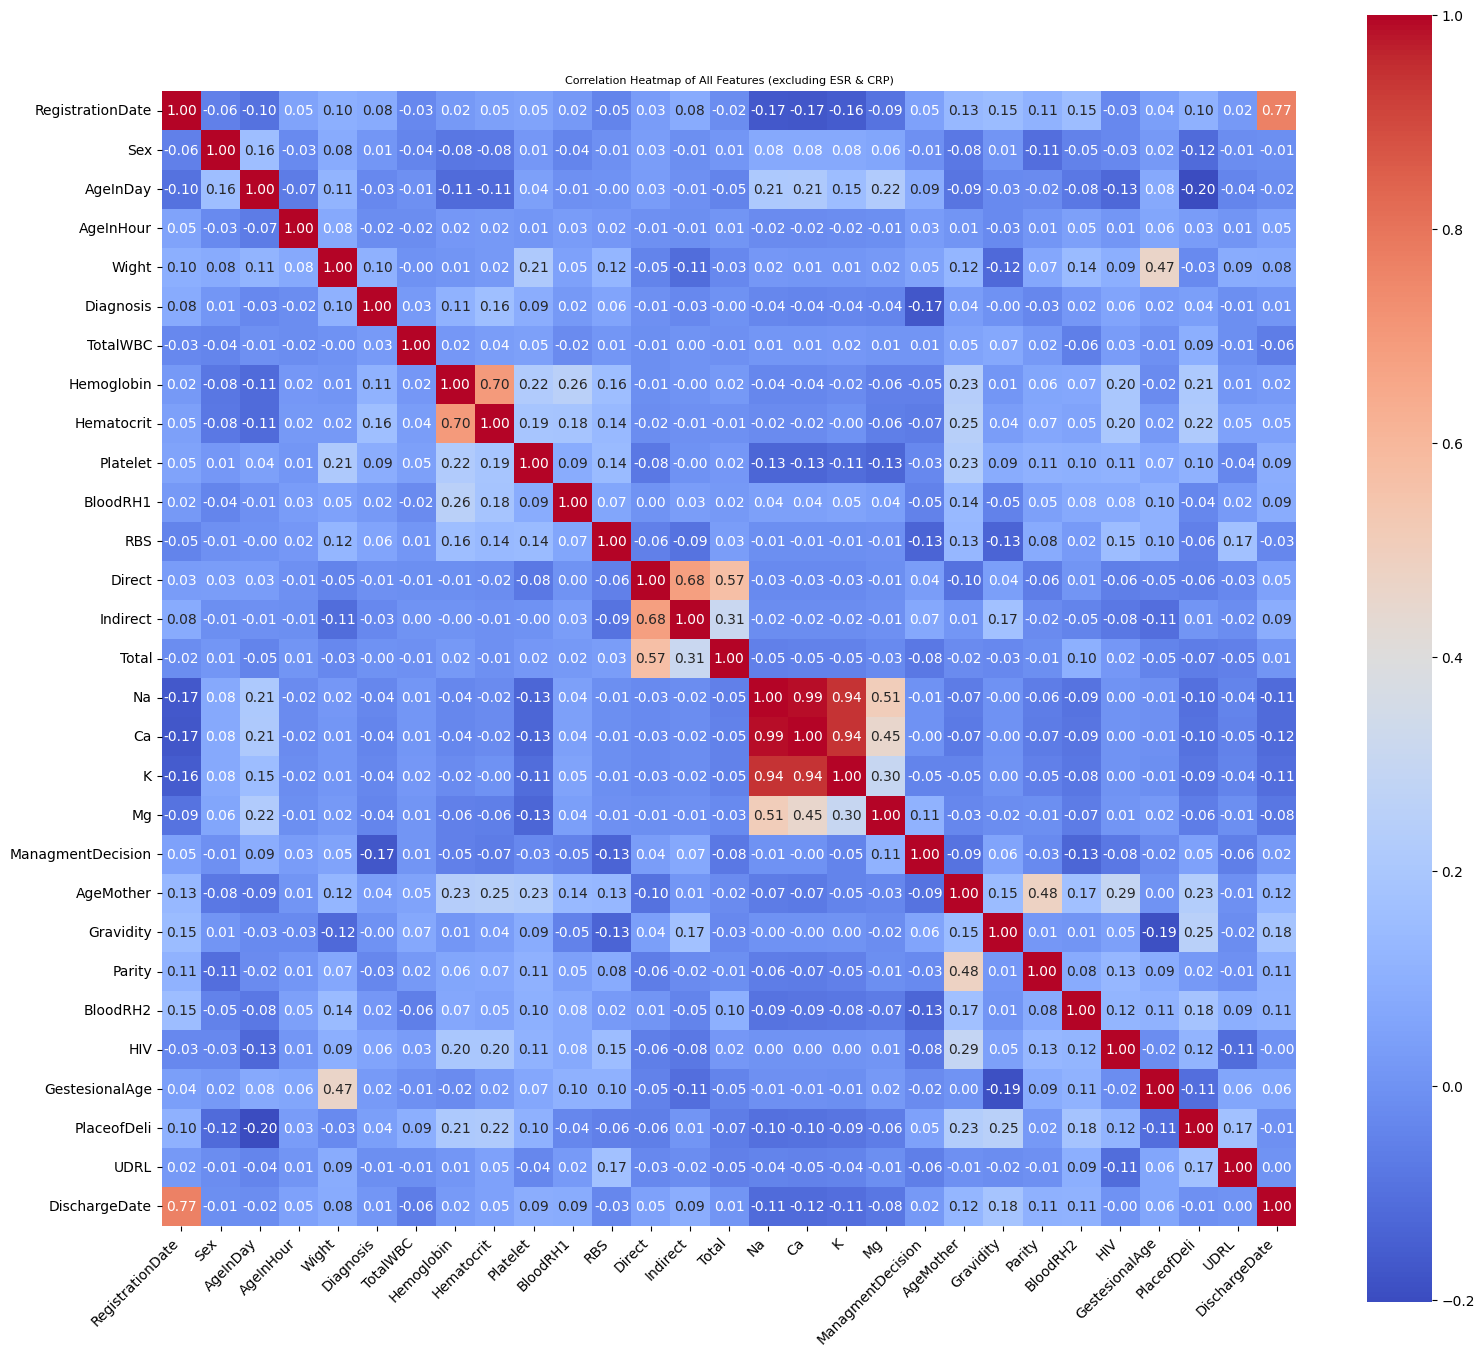

In [48]:
# Copy features
X = df_aug.drop(columns='DischargeCondition')

# List of columns to exclude
exclude_cols = ['ESR', 'CRP']  # add any other columns you want to skip

# Prepare encoded dataframe
X_encoded = pd.DataFrame()

for col in X.columns:
    if col in exclude_cols:
        continue  # skip excluded columns

    # 1️⃣ Handle datetime
    if np.issubdtype(X[col].dtype, np.datetime64):
        X_encoded[col] = (X[col] - X[col].min()).dt.total_seconds()

    # 2️⃣ Handle object columns
    elif X[col].dtype == 'object':
        try:
            X_encoded[col] = pd.to_datetime(X[col])
            X_encoded[col] = (X_encoded[col] - X_encoded[col].min()).dt.total_seconds()
        except:
            X_encoded[col] = LabelEncoder().fit_transform(X[col].astype(str))

    # 3️⃣ Numeric columns
    else:
        X_encoded[col] = X[col]

# Compute correlation matrix
corr = X_encoded.corr()

# Plot heatmap
plt.figure(figsize=(16,14))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap of All Features (excluding ESR & CRP)', fontsize=8)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [49]:
df_aug = clinical_entropy_matched_oversample(d, total_size=2067, noise_level=0.02, target_col='DischargeCondition')
print(d.shape, df_aug.shape)

(1180, 32) (2065, 32)


In [50]:
# Features / target
X = df_aug.drop(columns='DischargeCondition')
y = df_aug['DischargeCondition']

# Encode categorical features and convert datetime to numeric
X_encoded = X.copy()
for col in X_encoded.columns:
    if np.issubdtype(X_encoded[col].dtype, 'datetime64[ns]'):
        # Convert datetime to numeric (seconds since min)
        X_encoded[col] = (X_encoded[col] - X_encoded[col].min()).dt.total_seconds()
    elif X_encoded[col].dtype == 'object':
        # Encode categorical columns
        X_encoded[col] = LabelEncoder().fit_transform(X_encoded[col].astype(str))

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Sanity check: shapes and class distribution
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("\ny_train class distribution:\n", y_train.value_counts(normalize=True))
print("\ny_test class distribution:\n", y_test.value_counts(normalize=True))

X_train shape: (1652, 31)
X_test shape: (413, 31)

y_train class distribution:
 DischargeCondition
Improved    0.482446
Died        0.251211
LAMA        0.161622
Transfer    0.104722
Name: proportion, dtype: float64

y_test class distribution:
 DischargeCondition
Improved    0.481840
Died        0.251816
LAMA        0.162228
Transfer    0.104116
Name: proportion, dtype: float64


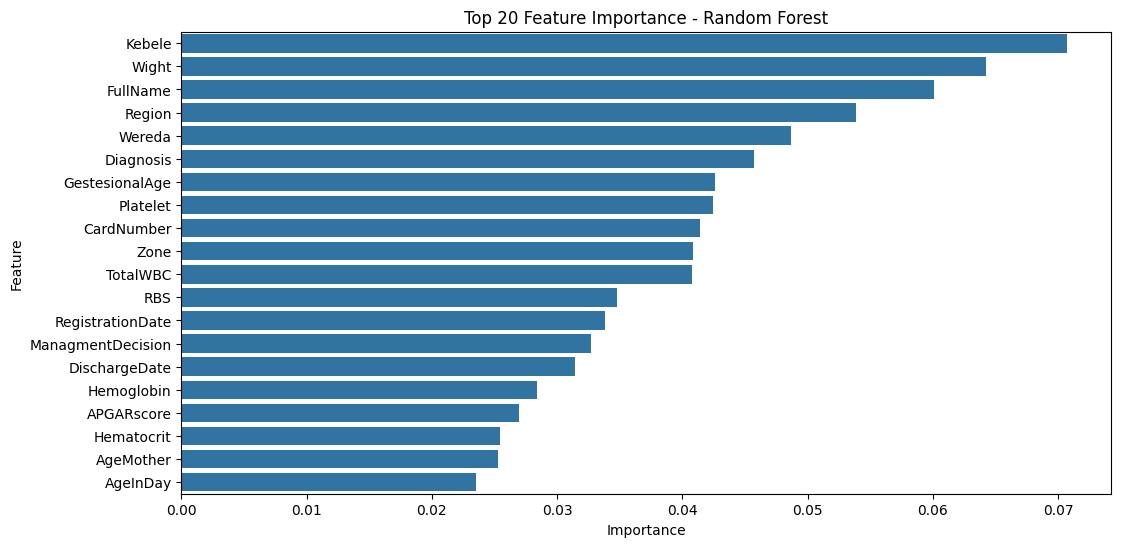

In [34]:
# Initialize Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit model
rf.fit(X_train, y_train)

# Create a Series of feature importances
feat_imp = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot top 20 features
plt.figure(figsize=(12,6))
sns.barplot(x=feat_imp[:20], y=feat_imp[:20].index)
plt.title("Top 20 Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [51]:
df_aug.shape

(2065, 32)